In [22]:
from astropy import table
import numpy as np
from pathlib import Path
from scipy import stats
import betterplotlib as bpl

bpl.set_style()

In [2]:
def get_all_catalogs(catalog_prefix):
    tables = []
    data_dir = Path("../data").resolve()
    for galaxy_dir in data_dir.iterdir():
        size_dir = galaxy_dir / "size"
        for file in size_dir.iterdir():
            if catalog_prefix in file.name and file.suffix == ".h5":
                new_table = table.Table.read(file, format="hdf5")
                new_table["galaxy"] = galaxy_dir.name
                tables.append(new_table)
    return tables

In [3]:
all_tables = get_all_catalogs("radialweighting3pix_abs_bgscale1e3_thetascale1e2_noaprior_noqprior_multiplestarts")

In [4]:
big_table = table.vstack(all_tables, join_type="inner")

In [24]:
std_cols = []
mad_cols = []
for col in big_table.colnames:
    if "x0_variations" in col:
        std_col = col.replace("x0_variations", "x0_std")
        mad_col = col.replace("x0_variations", "x0_mad")
        
        big_table[std_col] = np.std(big_table[col], axis=1)
        big_table[mad_col] = stats.median_abs_deviation(big_table[col], axis=1)
        
        std_cols.append(std_col)
        mad_cols.append(mad_col)
        
std_cols = std_cols[2:]  # throw out full image xy, keep snapshot xy
mad_cols = mad_cols[2:]  # throw out full image xy, keep snapshot xy

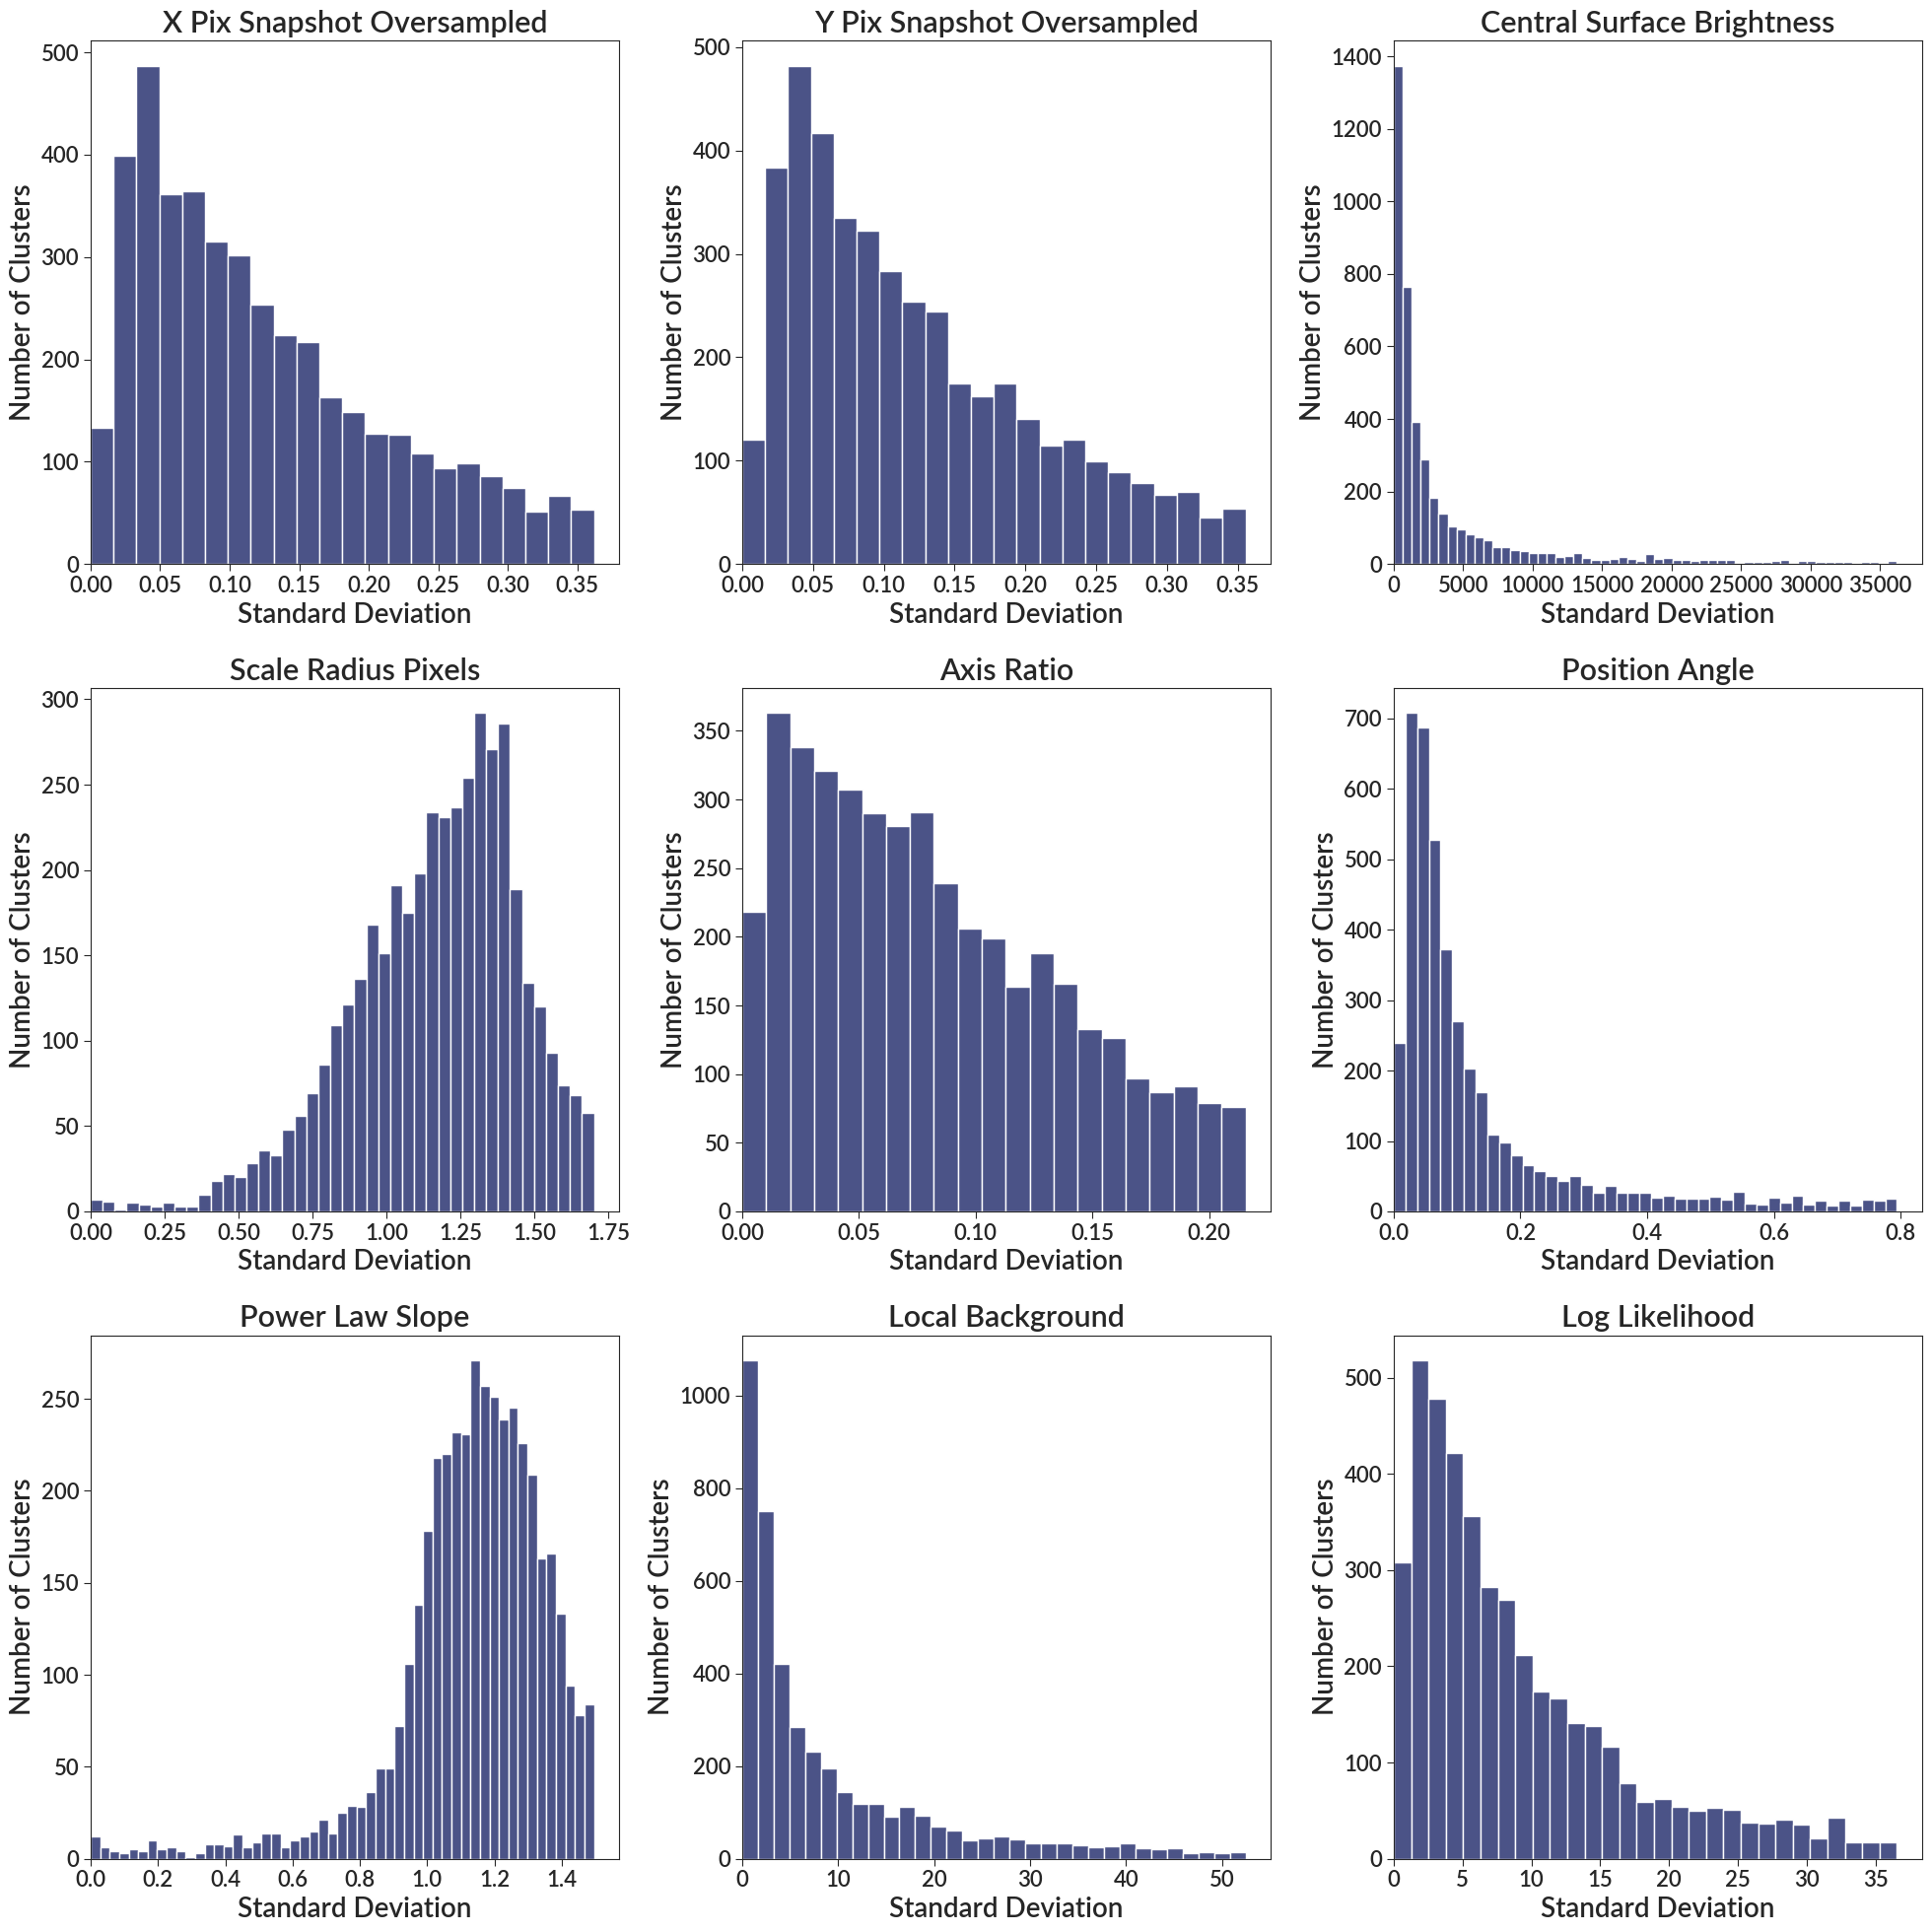

In [25]:
fig, axs = bpl.subplots(ncols=3, nrows=3, figsize=[20, 20])
axs = axs.flatten()
for ax, col in zip(axs, std_cols):
    data = big_table[col]
    
    bin_size = 0.1 * (np.percentile(data, 75) - np.percentile(data, 25))
    bins = np.arange(0, np.percentile(data, 90), bin_size)
    ax.hist(data, bins=bins)
    name = col[:-7].replace("_", " ").title()
    ax.add_labels("Standard Deviation", "Number of Clusters", name)
    ax.set_limits(0)

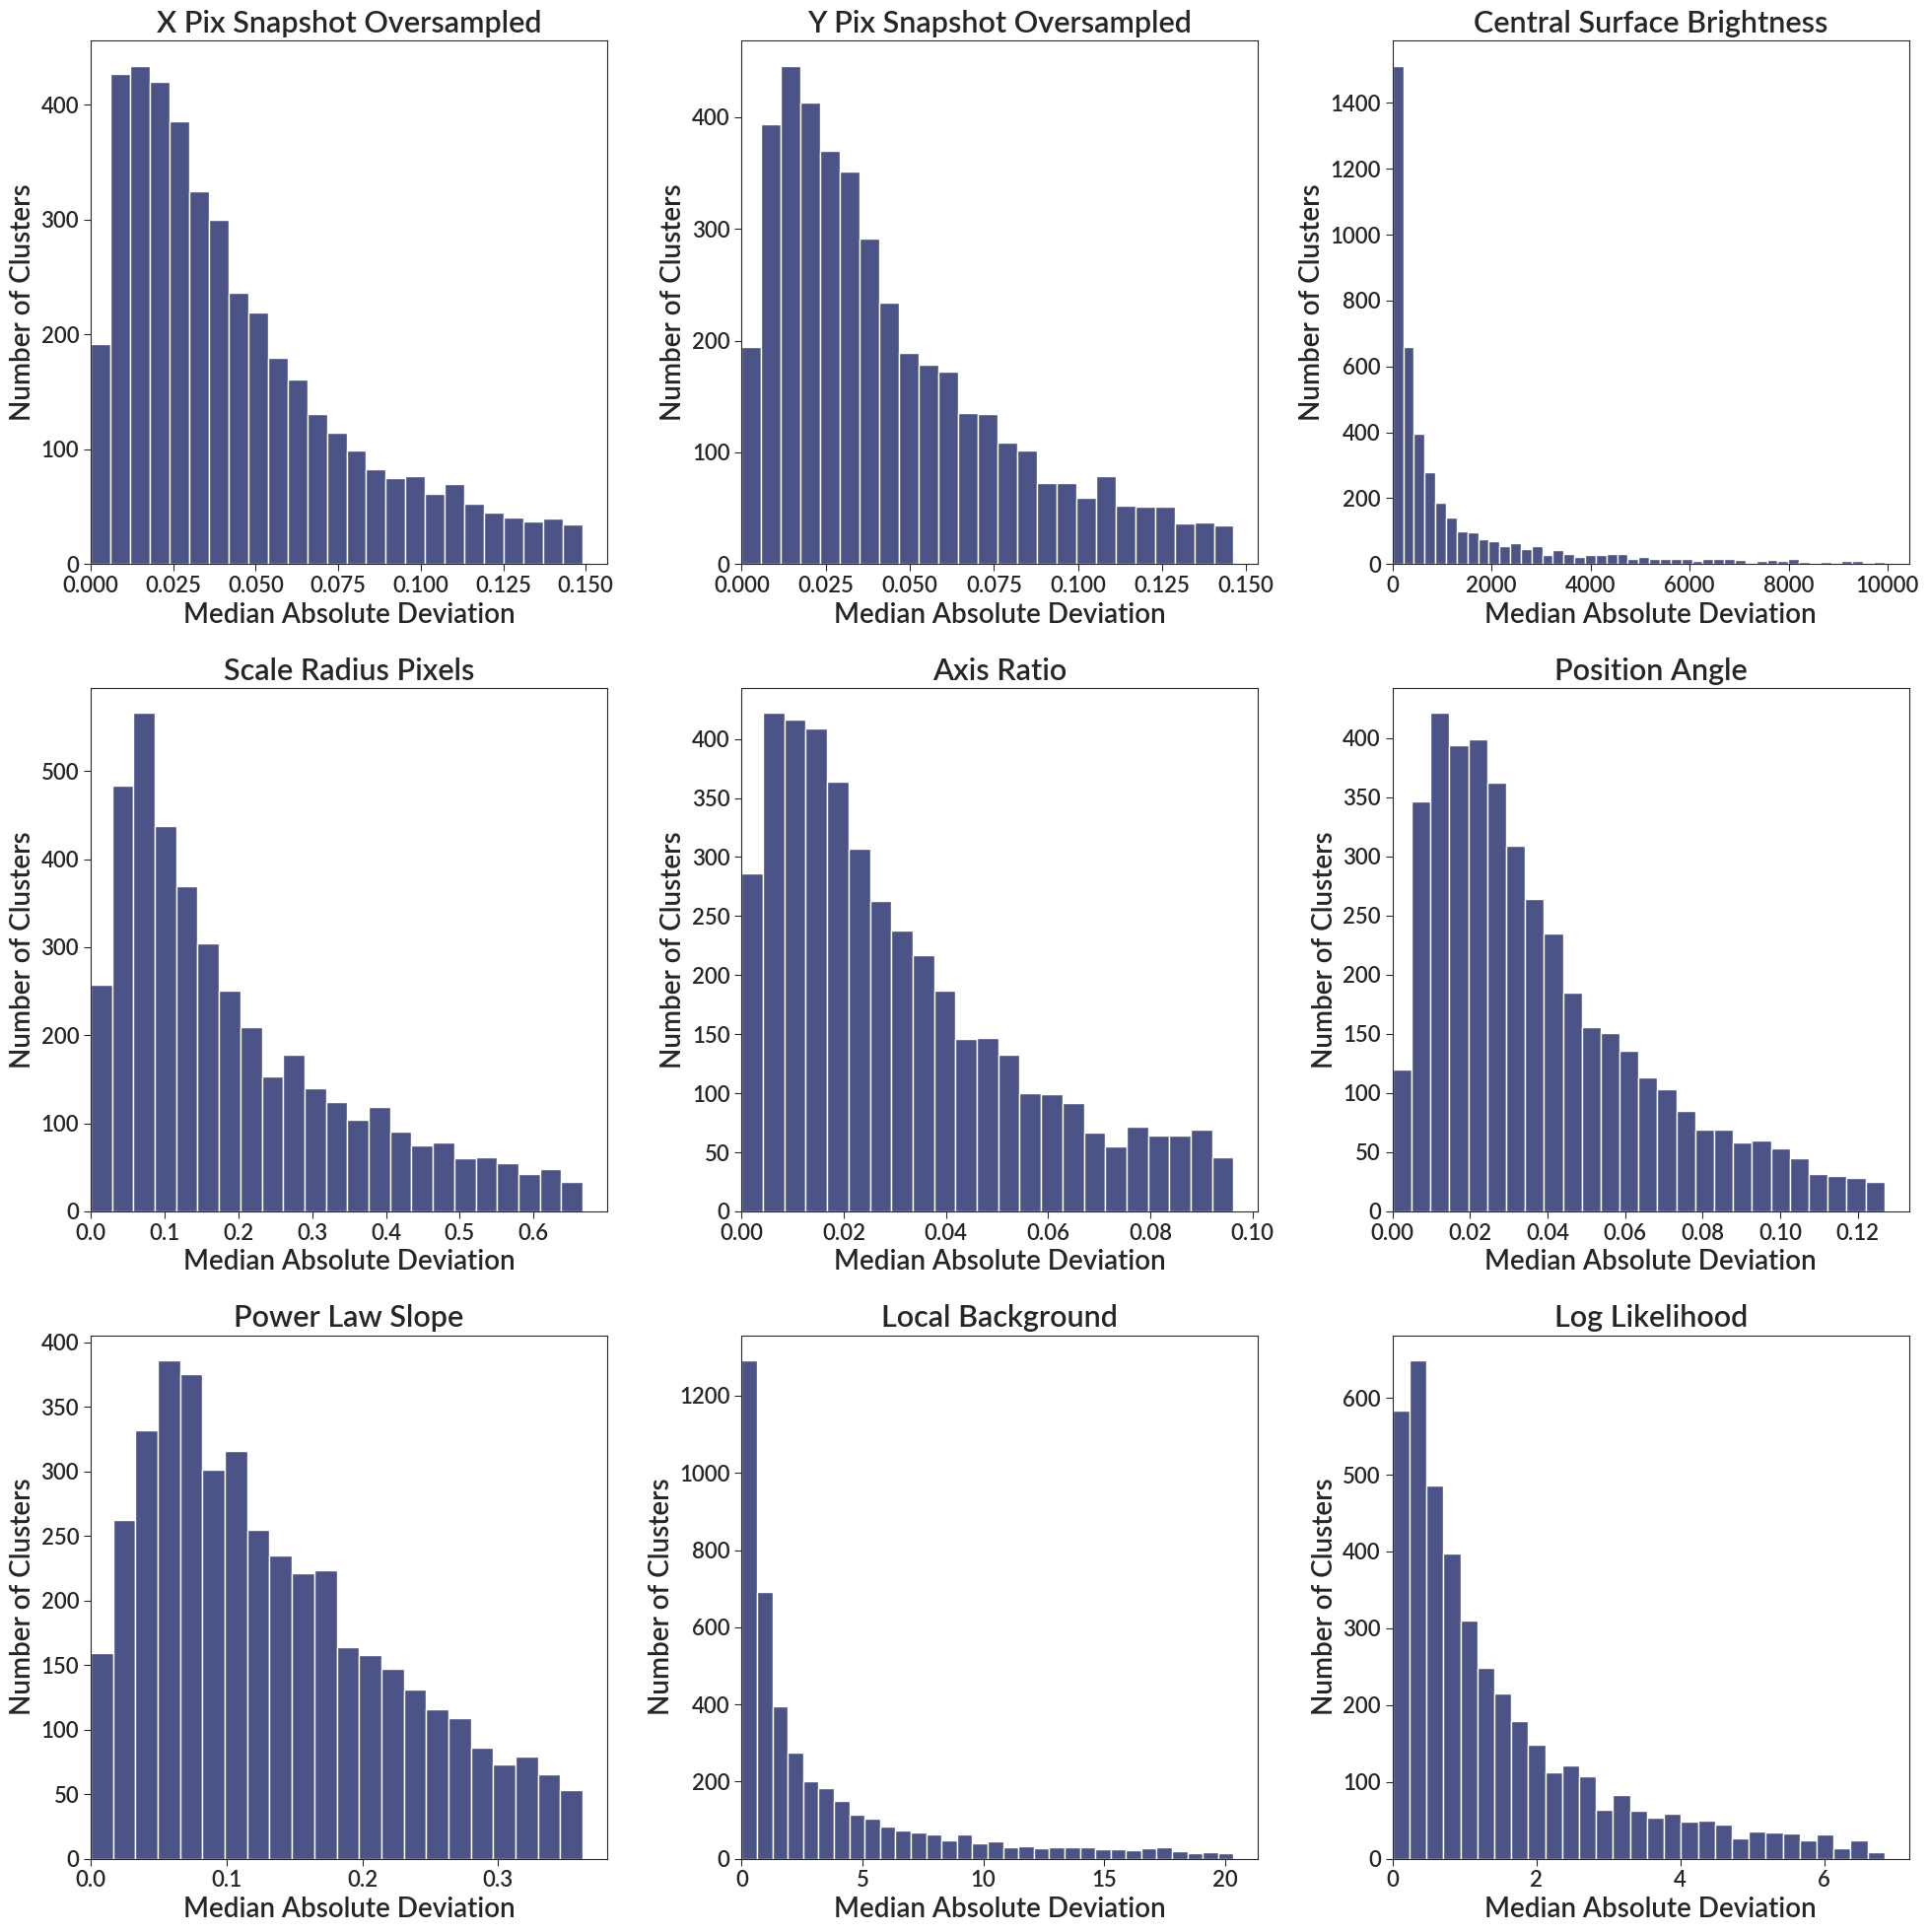

In [26]:
fig, axs = bpl.subplots(ncols=3, nrows=3, figsize=[20, 20])
axs = axs.flatten()
for ax, col in zip(axs, mad_cols):
    data = big_table[col]
    
    bin_size = 0.1 * (np.percentile(data, 75) - np.percentile(data, 25))
    bins = np.arange(0, np.percentile(data, 90), bin_size)
    ax.hist(data, bins=bins)
    name = col[:-7].replace("_", " ").title()
    ax.add_labels("Median Absolute Deviation", "Number of Clusters", name)
    ax.set_limits(0)

# Punchline is that things are not convergin